In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load

cfg = quick_load.load_cfg(overrides=['task_group=fixed_protein_pharm_conditioning_cond_a']) # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
plinder_dataset = train_dataset.datasets['plinder']['no_links']

sys1 = plinder_dataset[('fixed_protein_pharmacophore_ligand_denovo_condensed', 1)]
sys2 = plinder_dataset[('fixed_protein_pharmacophore_ligand_denovo_condensed', 662)]

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [21]:
sys1.nodes['pharm'].data['x_1_true'].shape[0]

1

In [3]:
g_list = [sys1, sys2]
coms = [ g.nodes['lig'].data['x_1_true'].mean(dim=0) for g in g_list ]

ckpt_path = '/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-08-27/fixed_protein_pharm_conditioning_conda_2025-08-27_14-39-368423/checkpoints/batch_10000.ckpt'
model = quick_load.omtra_from_checkpoint(ckpt_path).eval()

sampled_systems = model.sample(g_list=g_list,
                                              n_replicates=1,
                                              task_name='fixed_protein_pharmacophore_ligand_denovo_condensed',
                                              unconditional_n_atoms_dist='plinder',
                                              device='cpu',
                                              visualize=False,
                                              coms=coms)

In [15]:
sample = sampled_systems[1]
sample.get_pharmacophore_from_graph(kind='gt')

{'coords': array([], shape=(0, 3), dtype=float32),
 'types': [],
 'types_idx': [],
 'types_elems': []}

In [17]:
from omtra.eval.pharmacophore import compute_pharmacophore_match

compute_pharmacophore_match(sampled_systems)

{'frac_pharm_samples_matching': 0.0,
 'frac_true_centers_matched': 0.0,
 'frac_gen_centers_extra': 1.0}

In [ ]:
import zarr 

index = 662
root = zarr.open('/net/galaxy/home/koes/ltoft/OMTRA/data/plinder/no_links/train.zarr', mode='r')
system_lookup = pd.DataFrame(root.attrs["system_lookup"])

system_info = system_lookup[system_lookup["system_idx"] == index].iloc[0]
pharm_start, pharm_end = (system_info["pharm_start"], system_info["pharm_end"])
print('Number of pharmacophore centers:', pharm_end - pharm_start)



Number of pharmacophore centers: 23


In [9]:
sys = plinder_dataset[('fixed_protein_ligand_pharmacophore_denovo_condensed', 615)]

In [9]:
sys = plinder_dataset[('fixed_protein_ligand_pharmacophore_denovo_condensed', 8)]
sys.nodes['pharm'].data['x_0']

tensor([[ 27.9531, -40.5604,  44.2333],
        [ 26.9535, -42.1712,  45.5673],
        [ 27.4226, -43.1513,  47.2326],
        [ 25.3367, -42.0089,  45.9797],
        [ 25.5234, -43.5810,  43.1127]])

# Model Comparison

In [4]:
def compare_dist_w_true(data, metric, labels):

    flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)

    # Boxplot
    sns.boxplot(data=data, x="model", y=metric, hue="model", flierprops=flierprops, showfliers=True, palette="Set2")

    y_lower, y_upper = labels['bounds']

    plt.title(labels['title'])
    plt.xlabel(None)
    plt.xticks(rotation=45)
    plt.ylabel(labels['ylabel'])
    plt.ylim(y_lower, y_upper)
    plt.show()
        

def generate_plots(data):

    # generic box plots
    metrics = {'minimizedAffinity': {'title': 'Vina', 'ylabel': 'Vina score (kcal/mol)', 'bounds': (-15,10)},
               'vina_min': {'title': 'Vina min', 'ylabel': 'Vina min score (kcal/mol)', 'bounds': (-15, 10)},
               'strain': {'title': 'Strain', 'ylabel': 'Strain energy', 'bounds': (-10, 1000)},
               'clashes': {'title': 'Clashes', 'ylabel': '# clashes', 'bounds': (-5, 80)}}
   
    for metric, labels in metrics.items():
        compare_dist_w_true(data=data, metric=metric, labels=labels)


    # vina score system-level comparison
    sys_avg_data = data.groupby(['model', 'sys_id'])["minimizedAffinity"].mean().reset_index()

    # Sort by ascending vina score
    sys_order = sys_avg_data[sys_avg_data["model"] == "true"].sort_values("minimizedAffinity", ascending=False)["sys_id"].tolist()
    sys_avg_data["sys_id"] = pd.Categorical(sys_avg_data["sys_id"], categories=sys_order, ordered=True)
    
    plt.figure(figsize=(12, 10))

    sns.lineplot(
        x="sys_id", 
        y="minimizedAffinity", 
        hue="model", 
        data=sys_avg_data, 
        palette='Set2',
        legend=False
    )

    sns.scatterplot(
        x="sys_id", 
        y="minimizedAffinity", 
        hue="model", 
        data=sys_avg_data, 
        palette='Set2',
    )

    plt.gca().invert_yaxis()

    labels = plt.gca().get_xticklabels()
    for i, label in enumerate(labels):
        if i % 5 != 0:
            label.set_visible(False)

    ax = plt.gca()
    for pos in range(0, len(sys_order), 5):
        ax.axvline(x=pos, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean Vina score")
    plt.tight_layout()
    plt.show()

    # rmsd
    plt.figure(figsize=(6,4))
    flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)
    # Boxplot
    sns.boxplot(data=data[data['model'] != 'true'], x="model", y='rmsd', hue="model", flierprops=flierprops, showfliers=True, palette="Set2")

    plt.title('RMSD')
    plt.xlabel(None)
    plt.xticks(rotation=30)
    plt.ylabel('RMSD')
    plt.show()


def pb_validity_summary(data):
    avg_pb_metrics = {}

    for col in data.columns:
        avg_pb_metrics[col] = data[col].mean()

    sorted_pb_metrics = sorted(avg_pb_metrics.items(), key=lambda item: item[1])

    # Print sorted key-value pairs
    for key, value in sorted_pb_metrics:
        print(f"{key}: {value}")

In [11]:
# rigid docking
rd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/rigid_docking_condensed_metrics.csv')
rd_metrics['model'] = 'rigid_docking'
# flexible docking
fd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/flexible_docking_condensed_metrics.csv')
fd_metrics['model'] = 'flexible_docking'

# rigid protein, ligand de novo
rdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/fixed_protein_ligand_denovo_condensed_metrics.csv')
rdenovo_metrics['model'] = 'rigid_prot_lig_denovo'
# flexible protein, ligand de novo
fdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/protein_ligand_denovo_condensed_metrics.csv')
fdenovo_metrics['model'] = 'flexible_prot_lig_denovo'

In [12]:
true = rd_metrics[[col for col in rd_metrics.columns if '_true' in col and 'pb_mol_true_loaded' != col]].copy()
true.columns = [col[:-5] for col in true]
true[['sys_id', 'system_id', 'ligand_id', 'ccd']] = rd_metrics[['sys_id', 'system_id', 'ligand_id', 'ccd']]
true['model'] = 'true'
true = true.drop_duplicates(subset=['sys_id'])
true

,pb_mol_pred_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_bond_lengths,pb_bond_angles,pb_internal_steric_clash,pb_aromatic_ring_flatness,pb_non-aromatic_ring_non-flatness,...,strain,HBAcceptor,HBDonor,Hydrophobic,PiStacking,sys_id,system_id,ligand_id,ccd,model
0,True,True,True,True,True,True,True,True,True,True,...,4.336892e+00,0.333333,0.222222,0.000000,0.0,sys_0_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,true
50,True,True,True,True,True,True,True,True,True,True,...,4.397937e+02,0.161290,0.032258,0.096774,0.0,sys_1_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.K,ATP,true
100,True,True,True,True,True,True,True,True,True,True,...,2.431327e+01,0.166667,0.166667,0.083333,0.0,sys_2_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.L,CIR,true
150,True,True,True,True,True,True,True,True,True,True,...,2.351027e+01,0.555556,0.222222,0.000000,0.0,sys_3_gt,5yft__1__2.C__2.N,2.N,RI2,true
200,True,True,True,True,True,True,True,True,True,True,...,3.688895e+01,0.153846,0.115385,0.269231,0.0,sys_4_gt,4rrd__1__1.A_2.A__1.B,1.B,A3T,true
250,True,True,True,True,True,True,True,True,True,True,...,2.029865e+01,0.051282,0.051282,0.076923,0.0,sys_5_gt,3t1n__2__1.B__1.D,1.D,SEP-ASP-GLU-PHE,true
300,True,True,True,True,True,True,True,True,True,True,...,3.254752e+01,0.111111,0.111111,0.185185,0.0,sys_6_gt,6jat__1__1.A_1.B__1.E,1.E,SFG,true
350,True,True,True,True,True,True,True,True,True,True,...,7.915093e+00,0.105263,0.105263,0.368421,0.0,sys_7_gt,6c3u__1__1.A_1.B__1.G_1.H,1.G,NY2,true
400,True,True,True,True,True,True,True,True,True,True,...,6.161298e+01,0.129032,0.064516,0.129032,0.0,sys_8_gt,4jxx__1__1.A__1.C,1.C,ATP,true
450,True,True,True,True,True,True,True,True,True,True,...,3.476261e+01,0.064516,0.064516,0.064516,0.0,sys_9_gt,4bls__1__1.B_1.C__1.F,1.F,APC,true


In [5]:
# pair losses
# rigid docking
rd_metrics_pl = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_pair_losses_2025-08-23_15-59-495873/rigid_docking_condensed_metrics.csv')
rd_metrics_pl['model'] = 'rigid_docking_pl'
# flexible docking
#fd_metrics_pl = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_pair_losses_2025-08-23_15-59-495873/fixed_protein_ligand_denovo_condensed_metrics.csv')
#fd_metrics_pl['model'] = 'flexible_docking_pl'

# Beta t distribution
# rigid docking
rd_metrics_betat = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_rigidp_betat_2025-08-20_16-15-483811/rigid_docking_condensed_metrics.csv')
rd_metrics_betat['model'] = 'rigid_docking_betat'
# flexible docking
#fd_metrics_betat = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_rigidp_betat_2025-08-20_16-15-483811/fixed_protein_ligand_denovo_condensed_metrics.csv')
#fd_metrics_betat['model'] = 'flexible_docking_betat'


# Categorical loss weighting
# rigid docking
rd_metrics_catloss = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_rigidp_catloss_2025-08-21_11-45-534197/rigid_docking_condensed_metrics.csv')
rd_metrics_catloss['model'] = 'rigid_docking_catloss'
# flexible docking
#fd_metrics_catloss = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_rigidp_catloss_2025-08-21_11-45-534197/fixed_protein_ligand_denovo_condensed_metrics.csv')
#fd_metrics_catloss['model'] = 'flexible_docking_catloss'

# Time-scaled loss
# rigid docking
rd_metrics_tsloss = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_rigidp_tsloss_2025-08-21_14-53-340793/rigid_docking_condensed_metrics.csv')
rd_metrics_tsloss['model'] = 'rigid_docking_tsloss'
# flexible docking
#fd_metrics_tsloss = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_rigidp_tsloss_2025-08-21_14-53-340793/fixed_protein_ligand_denovo_condensed_metrics.csv')
#fd_metrics_tsloss['model'] = 'flexible_docking_tsloss'

In [6]:
true = rd_metrics_pl[[col for col in rd_metrics_pl.columns if '_true' in col and 'pb_mol_true_loaded' != col]].copy()
true.columns = [col[:-5] for col in true]
true[['sys_id', 'system_id', 'ligand_id', 'ccd']] = rd_metrics_pl[['sys_id', 'system_id', 'ligand_id', 'ccd']]
true['model'] = 'true'
true = true.drop_duplicates(subset=['sys_id'])
true

,pb_mol_pred_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_bond_lengths,pb_bond_angles,pb_internal_steric_clash,pb_aromatic_ring_flatness,pb_non-aromatic_ring_non-flatness,...,minimizedAffinity,CNNscore,CNNaffinity,CNNaffinity_variance,vina_min,sys_id,system_id,ligand_id,ccd,model
0,True,True,True,True,True,True,True,True,True,True,...,-2.97562,0.733135,3.004231,0.530241,-4.04023,sys_0_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,true
50,True,True,True,True,True,True,True,True,True,True,...,-6.69706,0.648176,5.209675,0.121130,-8.89318,sys_1_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.K,ATP,true
100,True,True,True,True,True,True,True,True,True,True,...,-5.72963,0.919273,4.932199,0.164473,-6.69169,sys_2_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.L,CIR,true
150,True,True,True,True,True,True,True,True,True,True,...,-9.43334,0.971446,5.720021,0.329662,-10.42666,sys_3_gt,5yft__1__2.C__2.N,2.N,RI2,true
200,True,True,True,True,True,True,True,True,True,True,...,-9.72386,0.984739,5.519279,0.934527,-10.46743,sys_4_gt,4rrd__1__1.A_2.A__1.B,1.B,A3T,true
250,True,True,True,True,True,True,True,True,True,True,...,-3.72965,0.893999,5.621475,0.106749,-4.80368,sys_5_gt,3t1n__2__1.B__1.D,1.D,SEP-ASP-GLU-PHE,true
300,True,True,True,True,True,True,True,True,True,True,...,-9.69120,0.955618,6.769628,0.006293,-10.30882,sys_6_gt,6jat__1__1.A_1.B__1.E,1.E,SFG,true
350,True,True,True,True,True,True,True,True,True,True,...,-6.17614,0.347033,5.296873,0.649141,-6.76915,sys_7_gt,6c3u__1__1.A_1.B__1.G_1.H,1.G,NY2,true
400,True,True,True,True,True,True,True,True,True,True,...,-8.78159,0.901289,5.233379,0.024521,-9.38502,sys_8_gt,4jxx__1__1.A__1.C,1.C,ATP,true
450,True,True,True,True,True,True,True,True,True,True,...,-7.94802,0.783886,4.678255,0.028989,-9.01415,sys_9_gt,4bls__1__1.B_1.C__1.F,1.F,APC,true


In [7]:
all_results = pd.concat([rd_metrics_pl, rd_metrics_catloss, rd_metrics_betat, rd_metrics_tsloss, true], ignore_index=True)
all_results.drop(columns=[col for col in all_results.columns if '_true' in col and 'pb_mol_true_loaded' != col], inplace=True)
all_results

,sys_id,protein_id,gen_ligand_id,RDKit_valid,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,...,minimizedAffinity,CNNscore,CNNaffinity,CNNaffinity_variance,vina_min,rmsd,system_id,ligand_id,ccd,model
0,sys_0_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,-3.34801,0.530362,2.892530,0.536846,-4.59632,3.314705,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking_pl
1,sys_0_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,-2.76597,0.671797,2.926240,0.278769,-3.90244,3.198960,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking_pl
2,sys_0_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,True,...,-2.86304,0.295032,2.751506,0.602253,-4.41433,1.721724,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking_pl
3,sys_0_gt,protein_0,gen_ligands_3,True,True,True,True,True,True,True,...,-3.65048,0.517028,3.034271,0.649467,-4.35643,2.433985,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking_pl
4,sys_0_gt,protein_0,gen_ligands_4,True,True,True,True,True,True,True,...,0.54745,0.663432,3.229742,0.307345,-4.06191,2.982562,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking_pl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,sys_45_gt,NaN,NaN,NaN,True,NaN,True,True,True,True,...,-2.02413,0.837858,5.757616,0.205773,-5.37857,NaN,5b5t__2__1.C_1.D__1.G,1.G,6FY,true
10046,sys_46_gt,NaN,NaN,NaN,True,NaN,True,True,True,True,...,-7.59594,0.878219,6.492582,1.505714,-8.08239,NaN,5eu9__2__1.C__1.O_1.P_1.R,1.R,5TX,true
10047,sys_47_gt,NaN,NaN,NaN,True,NaN,True,True,True,True,...,-7.56657,0.377345,5.306210,0.394620,-7.93146,NaN,7xxc__1__1.A_1.B_1.C__1.J,1.J,I55,true
10048,sys_48_gt,NaN,NaN,NaN,True,NaN,True,True,True,True,...,-6.04646,0.971742,5.080473,0.394114,-6.61987,NaN,2znz__2__1.G_1.H_2.F__2.N,2.N,LYS,true


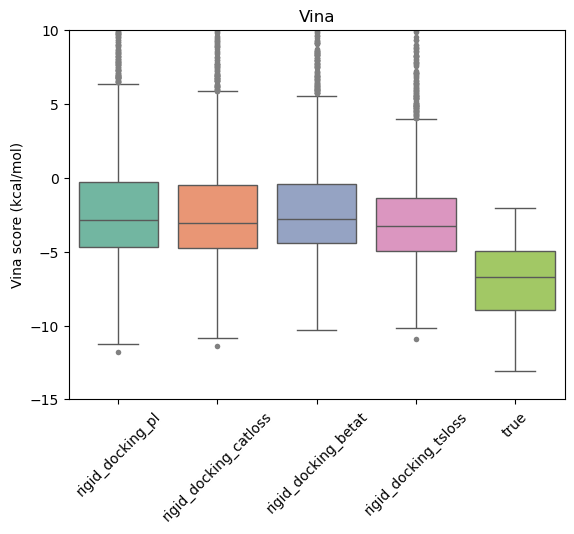

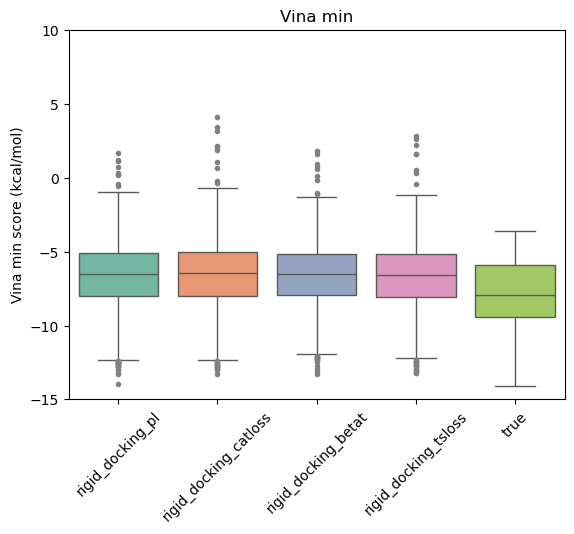

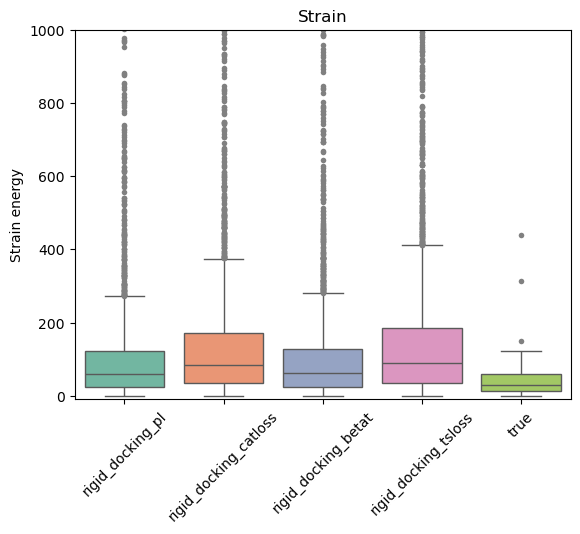

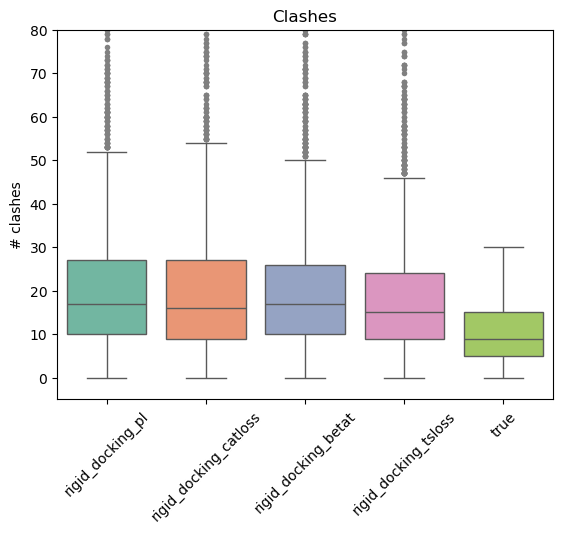

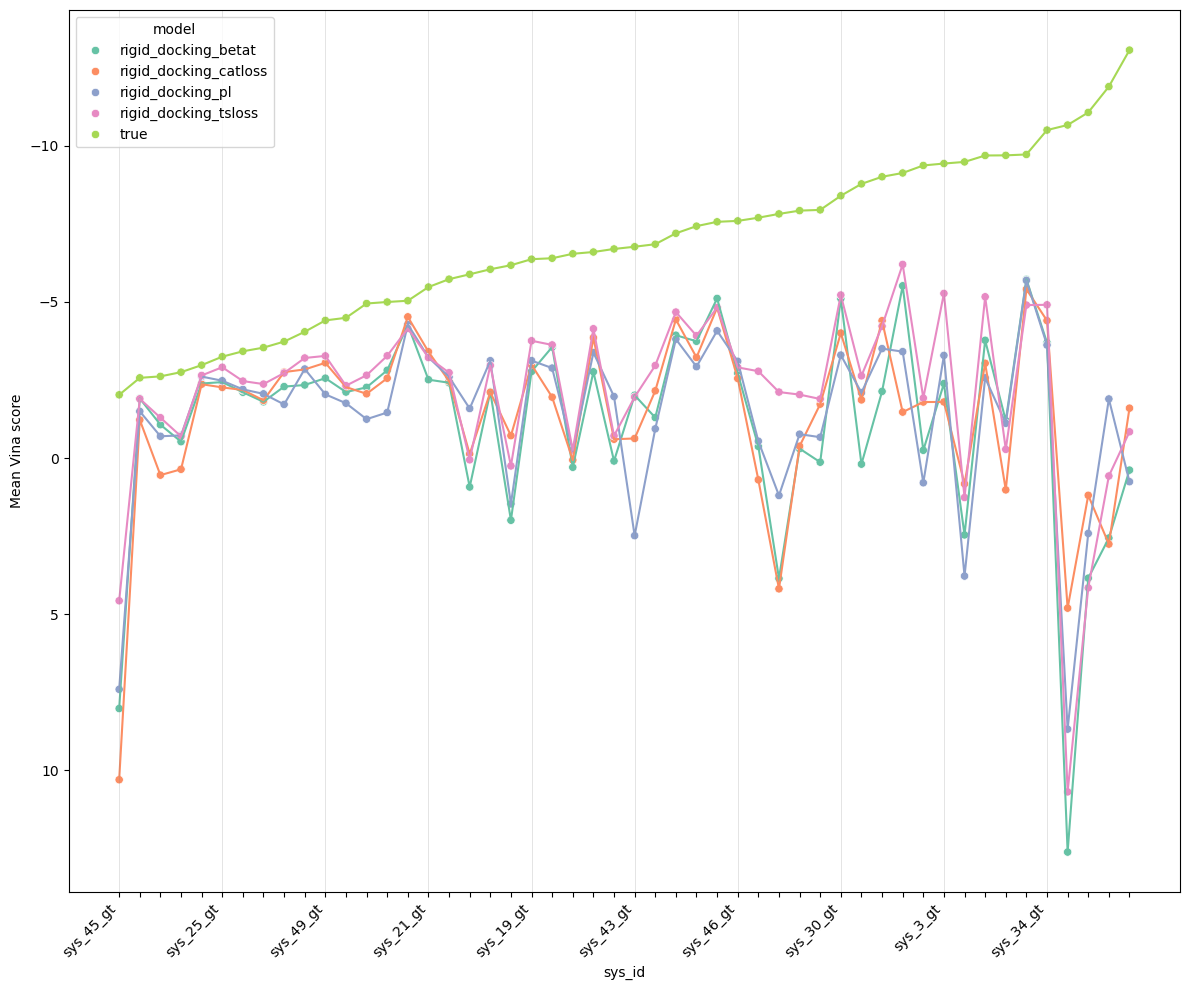

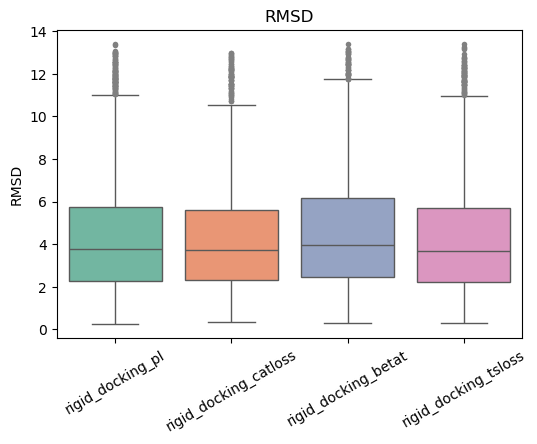

In [8]:
generate_plots(all_results)

In [9]:
# PoseBusters checks
pb_checks = [col for col in all_results if 'pb_' in col]
pb = all_results.copy()
pb = pb[pb_checks].copy()
pb[['model','sys_id']] = all_results[['model', 'sys_id']]

pb_summary = pd.DataFrame(index=pb_checks, columns=all_results['model'].unique())

for check in pb_checks:
    pb[check] = pd.to_numeric(pb[check], errors='coerce')
    sys_avg = pb.groupby(['model', 'sys_id'])[check].mean()
    model_avg = sys_avg.groupby('model').mean()

    pb_summary.loc[check, :] = model_avg

pb_summary

,rigid_docking_pl,rigid_docking_catloss,rigid_docking_betat,rigid_docking_tsloss,true
pb_mol_pred_loaded,1.0,1.0,1.0,1.0,1.0
pb_mol_true_loaded,1.0,1.0,1.0,1.0,NaN
pb_mol_cond_loaded,1.0,1.0,1.0,1.0,1.0
pb_sanitization,1.0,1.0,1.0,1.0,1.0
pb_inchi_convertible,1.0,1.0,1.0,1.0,1.0
pb_all_atoms_connected,1.0,1.0,1.0,1.0,1.0
pb_molecular_formula,1.0,1.0,1.0,1.0,NaN
pb_molecular_bonds,1.0,1.0,1.0,1.0,NaN
pb_double_bond_stereochemistry,1.0,1.0,1.0,1.0,NaN
pb_tetrahedral_chirality,0.4496,0.4448,0.4296,0.3948,NaN


In [10]:
# Table 2 from FLOWR
# 100 samples, 100 replicates

summary_table_1 = pd.DataFrame(index=all_results['model'].unique())
table_metrics = {'pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score',
                 'rmsd': 'RMSD'}

for metric, name in table_metrics.items():
    # ensure numeric; non-numeric -> NaN
    all_results[metric] = pd.to_numeric(all_results[metric], errors='coerce')
    
    sys_avg = all_results.groupby(['model', 'sys_id'])[metric].mean()
    mean = sys_avg.groupby('model').mean()
    std = sys_avg.groupby('model').std()
    
    # safely handle NaNs in formatting
    summary_table_1[name] = mean.round(3).astype(str).fillna('NaN') + " ± " + std.round(3).astype(str).fillna('NaN')

summary_table_1

,PB-valid,Strain,Vina score,Vina min score,RMSD
rigid_docking_pl,0.08 ± 0.106,141.863 ± 147.701,-1.36 ± 2.694,-6.648 ± 1.676,4.304 ± 1.653
rigid_docking_catloss,0.072 ± 0.097,168.659 ± 127.919,-1.421 ± 2.732,-6.574 ± 1.647,4.227 ± 1.427
rigid_docking_betat,0.063 ± 0.089,135.765 ± 151.047,-1.177 ± 3.263,-6.599 ± 1.554,4.541 ± 1.523
rigid_docking_tsloss,0.064 ± 0.088,195.146 ± 180.466,-2.146 ± 2.844,-6.705 ± 1.677,4.301 ± 1.452
true,0.9 ± 0.303,51.645 ± 74.93,-6.829 ± 2.666,-7.92 ± 2.5,nan ± nan


In [11]:
# Table 2 from DrugFlow

from scipy.stats import wasserstein_distance

models = list(set(all_results['model'].unique()) - {'true'})
summary_table_2 = pd.DataFrame(index=models)
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    true_dist = all_results.loc[all_results['model'] == 'true', metric].dropna().astype(np.float64).to_numpy()

    for model in models:
        data_dist = all_results.loc[all_results['model'] == model, metric].dropna().astype(np.float64).to_numpy()
        summary_table_2.loc[model, name] = wasserstein_distance(data_dist, true_dist) 

summary_table_2

,Vina score,Gnina score,H-bond (acc.),H-bond (don.),Hydrophobic
rigid_docking_pl,5.469084,0.449405,0.059101,0.039272,0.024321
rigid_docking_catloss,5.408340,0.463498,0.065646,0.044090,0.027226
rigid_docking_tsloss,4.682901,0.475696,0.068931,0.044266,0.026272
rigid_docking_betat,5.652242,0.480299,0.069900,0.045050,0.028232


# Single Model Analysis

In [45]:
metrics_path = '/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_pair_losses_2025-08-23_15-59-495873/rigid_docking_condensed_metrics.csv'
data = pd.read_csv(metrics_path)

In [46]:
import matplotlib.pyplot as plt

def plot_by_sys(data, metric, order="desc"):
   
    metric_true = f"{metric}_true"

    # Group by system
    grouped = data.groupby('sys_id')

    # Collect replicates + truths
    replicates = [g[metric].values for _, g in grouped]
    truths = [g[metric_true].iloc[0] for _, g in grouped]
    systems = list(grouped.groups.keys())

    # Sort systems by truth
    reverse = (order == "desc")
    ordered = sorted(zip(systems, replicates, truths), key=lambda x: x[2], reverse=reverse)
    systems, replicates, truths = zip(*ordered)

    # Plot
    fig, ax = plt.subplots(figsize=(12,6))
    bp = ax.boxplot(replicates, positions=range(len(systems)), patch_artist=True)
    ax.scatter(range(len(systems)), truths, color="red", marker="x", s=100, label="Ground truth")

    # Format axes
    ax.set_xticks(range(len(systems)))
    ax.set_xticklabels(systems, rotation=90, ha="right")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric}: replicates vs ground truth (sorted {order})")

    plt.tight_layout()
    return fig, ax

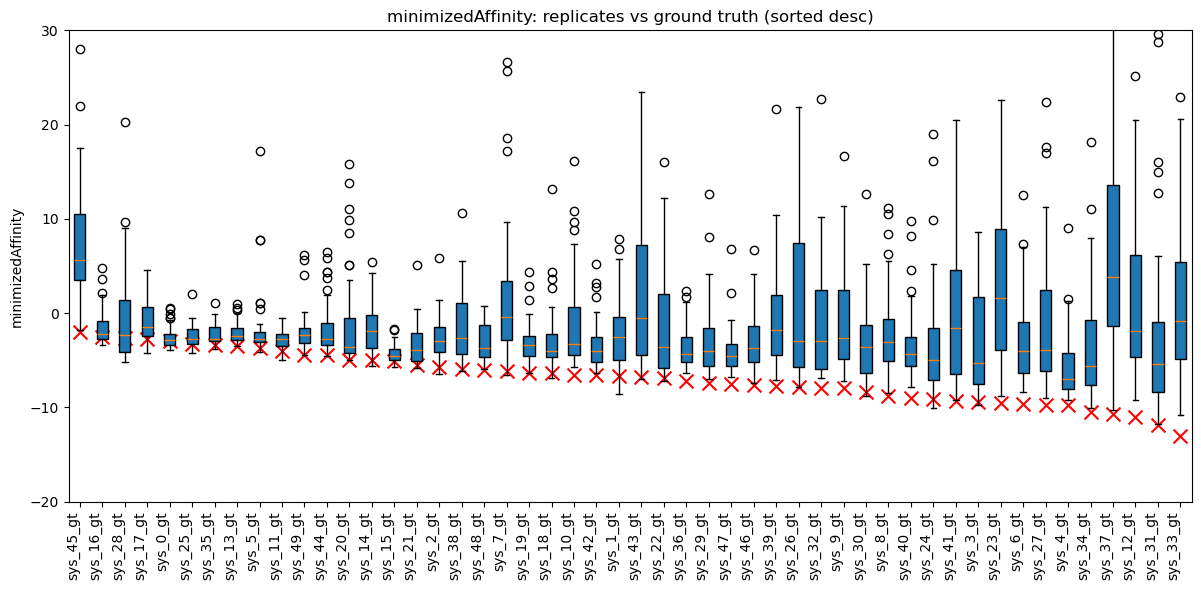

In [47]:
fig, ax = plot_by_sys(data, "minimizedAffinity", order="desc")

ax.set_ylim(-20, 30)
fig.show()

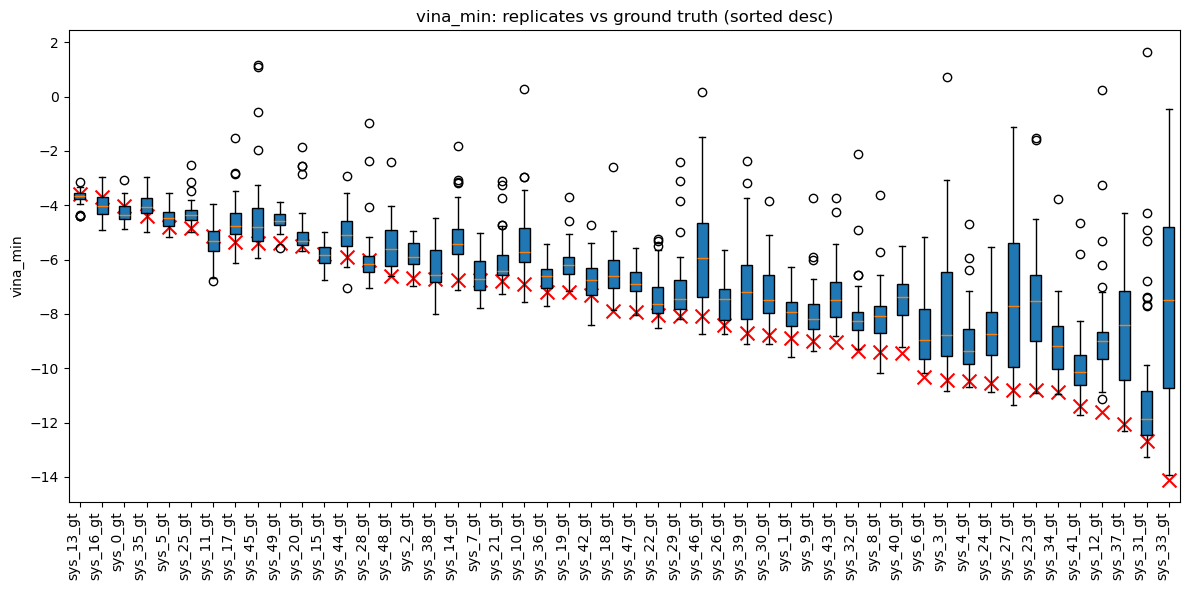

In [48]:
fig, ax = plot_by_sys(data, "vina_min", order="desc")

fig.show()

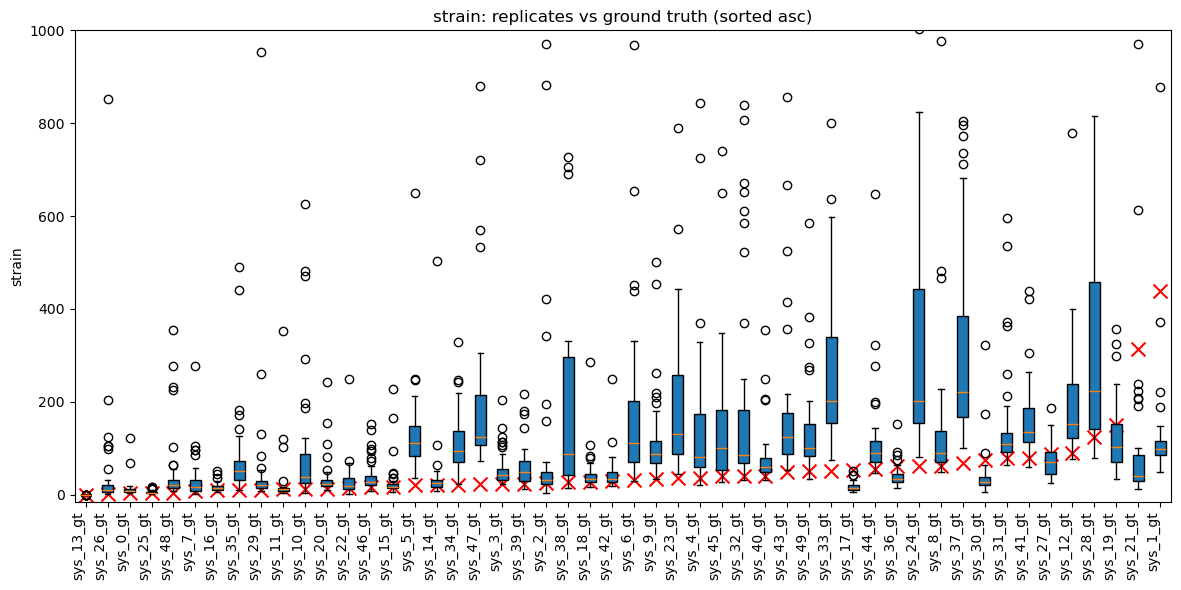

In [49]:
fig, ax = plot_by_sys(data, "strain", order="asc")

ax.set_ylim(-15, 1000)
fig.show()

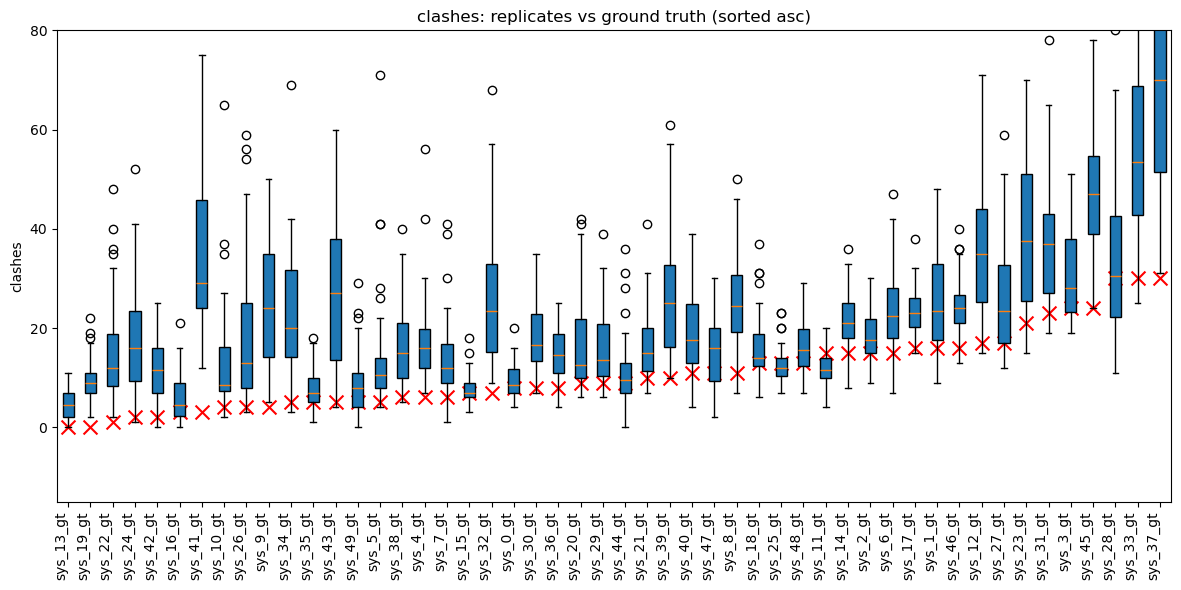

In [50]:
fig, ax = plot_by_sys(data, "clashes", order="asc")

ax.set_ylim(-15, 80)
fig.show()

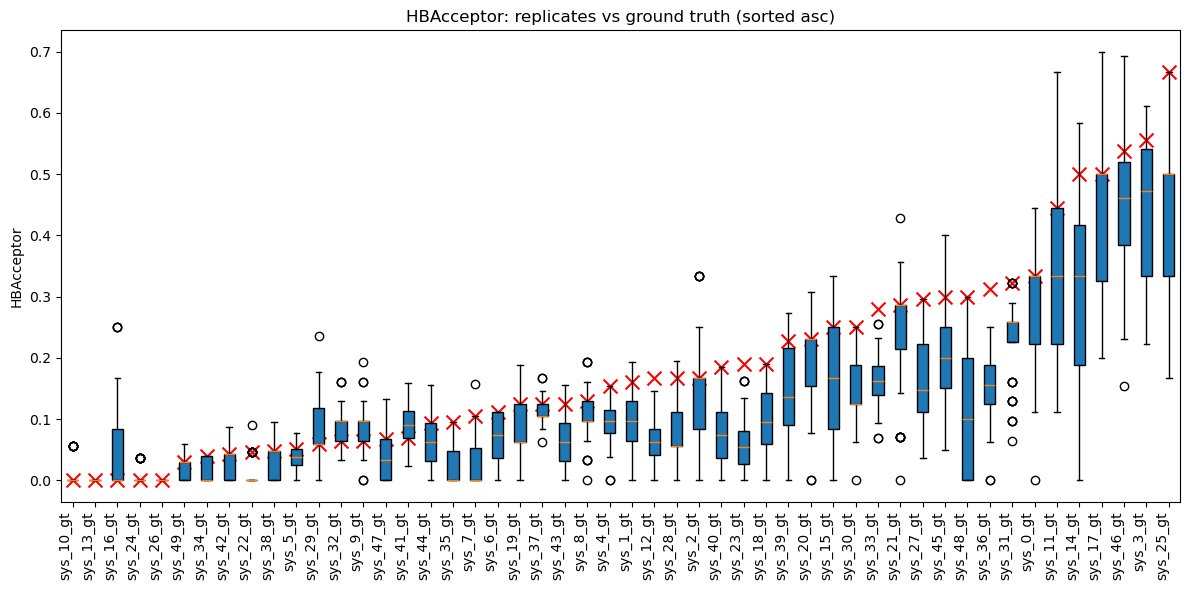

In [51]:
fig, ax = plot_by_sys(data, "HBAcceptor", order="asc")

#ax.set_ylim(-15, 80)
fig.show()

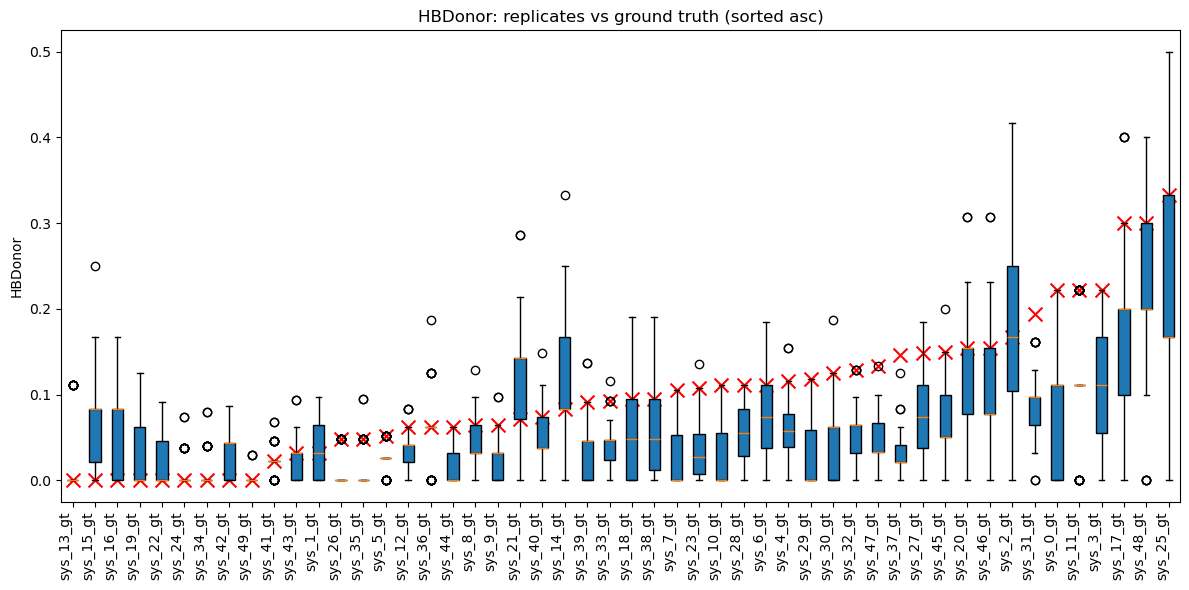

In [52]:
fig, ax = plot_by_sys(data, "HBDonor", order="asc")

#ax.set_ylim(-15, 80)
fig.show()

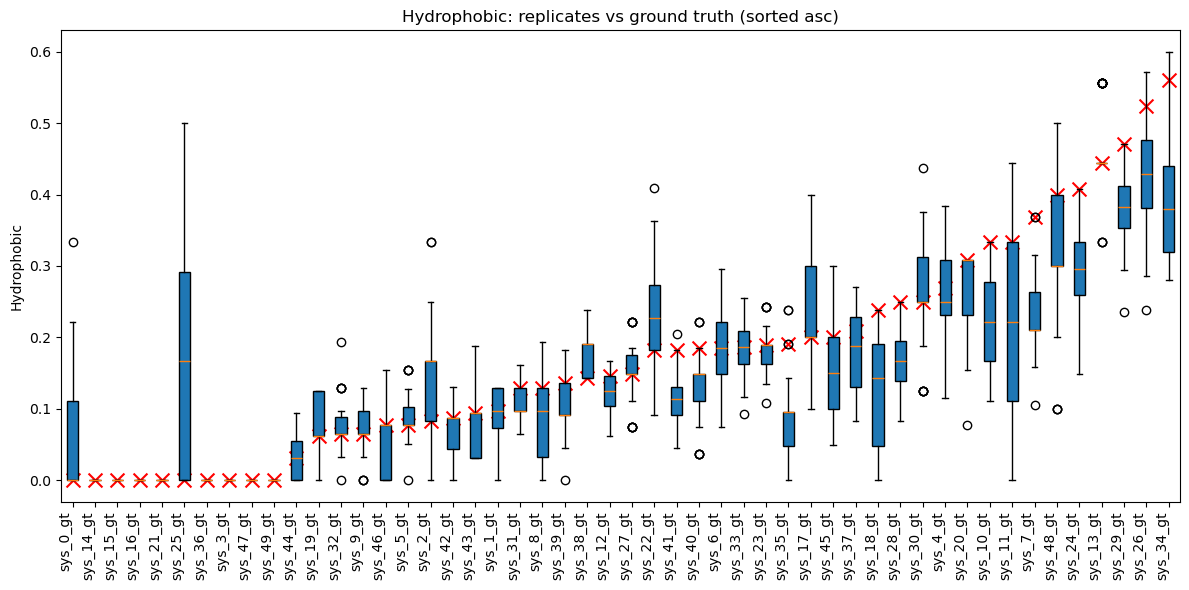

In [53]:
fig, ax = plot_by_sys(data, "Hydrophobic", order="asc")

#ax.set_ylim(-15, 80)
fig.show()